In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from pycytominer.cyto_utils import infer_cp_features
import sys
import matplotlib.pyplot as plt
sys.path.insert(0, "../scripts")
from utils import load_data
from scipy.stats import pearsonr, ttest_ind
import seaborn

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubun

In [2]:
np.random.seed(82)

In [3]:
data_dict = load_data(["complete"])
meta_features = infer_cp_features(data_dict["complete"], metadata=True)
cp_features = infer_cp_features(data_dict["complete"])

complete_features_df = data_dict["complete"].reindex(cp_features, axis="columns")
complete_meta_df = data_dict["complete"].reindex(meta_features, axis="columns")

In [4]:
latent_df = pd.read_csv("latent.csv").drop("Unnamed: 0", axis = 1)
moa_df = pd.read_csv("repurposing_info_external_moa_map_resolved.tsv",sep='\t').set_index('broad_sample').reindex(index=complete_meta_df['Metadata_broad_sample']).reset_index().drop('Metadata_broad_sample',axis = 1)
random_moa_labels = pd.DataFrame([moa_df.moa.sample(frac=1)]).transpose().reset_index().drop('index', axis = 1)
random_moa_labels = random_moa_labels.rename(columns={'moa': 'random_moa_labels'})
meta_moa_latent_df = pd.concat([complete_meta_df,moa_df,random_moa_labels,latent_df], axis=1)
meta_moa_complete_df = pd.concat([complete_meta_df,moa_df,random_moa_labels,complete_features_df], axis=1)
meta_moa_latent_df.head()
random_moa_labels

,random_moa_labels
0,NaN
1,aromatase inhibitor
2,MEK inhibitor
3,CCK receptor antagonist
4,serotonin receptor agonist
...,...
10363,dopamine receptor antagonist|serotonin recepto...
10364,proteasome inhibitor
10365,NFkB pathway inhibitor|proteasome inhibitor
10366,carbonic anhydrase inhibitor


In [5]:
meta_moa_latent_df.columns

Index(['Metadata_Plate_Map_Name', 'Metadata_broad_sample',
       'Metadata_pert_well', 'Metadata_mmoles_per_liter',
       'Metadata_dose_recode', 'Metadata_unique_id', 'broad_id', 'pert_iname',
       'InChIKey14', 'moa', 'target', 'broad_date', 'clinical_phase',
       'alternative_moa', 'alternative_target', 'random_moa_labels', '0', '1',
       '2', '3', '4'],
      dtype='object')

In [6]:
moas_occurrence = pd.read_csv("moas_occurrence.tsv", sep = "\t")
moas_occurrence.index = moas_occurrence['moa']
moas_occurrence = moas_occurrence.drop('moa', axis = 1)

#We only want moa combinations with enough data, so we pick A|B such that there are at least 5 A|B, 5 A, and 5 B.
valid_pipes = moas_occurrence[((moas_occurrence != 0).all(axis = 1)) & (moas_occurrence['full moa occurrence'] > 5) & (moas_occurrence['moa1 occurrence'] > 5)& (moas_occurrence['moa2 occurrence'] > 5)].index
valid_pipes = valid_pipes[valid_pipes.str.count("\|") == 1]

In [7]:
def subset_by_moa(pipe, df_name, column):
    moas = pipe.split("|")
    subset_df = pd.concat([df_name[df_name[column] == moas[0]],df_name[df_name[column] == moas[1]]])
    return subset_df

def LSA(A, B, D):
    return A-D+B

In [8]:
#calculate means for each A and B in each A|B.
subset_means = []
subset_random_means = []
valid_pipes_no_error = []
for pipe in valid_pipes:
    subset = subset_by_moa(pipe, meta_moa_latent_df, 'moa')
    subset_random = subset_by_moa(pipe, meta_moa_latent_df, 'random_moa_labels')
    subset_mean = subset.groupby(['moa'])[['0','1','2','3','4']].mean()
    subset_random_mean = subset_random.groupby(['random_moa_labels'])[['0','1','2','3','4']].mean()
    if subset_mean.shape[0] >= 2:
        subset_means.append(subset_mean)
        valid_pipes_no_error.append(pipe)
    if subset_random_mean.shape[0] >= 2:
        subset_random_means.append(subset_random_mean)


#calculate means for DMSO
DMSO = meta_moa_latent_df[meta_moa_latent_df.Metadata_broad_sample == 'DMSO']
DMSO_means = np.mean(DMSO[['0','1','2','3','4']])
DMSO_means

0   -0.036281
1    0.011534
2    0.343649
3    0.006927
4   -0.062942
dtype: float64

In [9]:
#perform latent space arithmetic
representations_after_LSA = []
representations_after_LSA_random = []
for i in range(len(subset_means)):
    representation_after_LSA = LSA(subset_means[i].loc[valid_pipes_no_error[i].split("|")[0]],subset_means[i].loc[valid_pipes_no_error[i].split("|")[1]],DMSO_means)
    representation_after_LSA = pd.DataFrame(representation_after_LSA).transpose()
    representations_after_LSA.append(representation_after_LSA)
    representation_after_LSA_random = LSA(subset_random_means[i].loc[valid_pipes_no_error[i].split("|")[0]],subset_random_means[i].loc[valid_pipes_no_error[i].split("|")[1]],DMSO_means)
    representation_after_LSA_random = pd.DataFrame(representation_after_LSA_random).transpose()
    representations_after_LSA_random.append(representation_after_LSA_random)

In [10]:
#decode each latent space representation
decoder = keras.models.load_model("../2.train/decoder")
reconstruction = pd.concat([moa_df,random_moa_labels,pd.DataFrame(decoder.predict(latent_df), columns = cp_features)], axis = 1)
predictions = []
predictions_random = []

for i in range(len(representations_after_LSA)):
    predictions.append(decoder.predict(representations_after_LSA[i]))
    predictions_random.append(decoder.predict(representations_after_LSA_random[i]))
predictions = np.array(predictions)
predictions_random = np.array(predictions_random)

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
#analyze results to see how good each prediction is to the actual value ranked against its distance to the values for other MOAs
mean_of_moas = meta_moa_complete_df.groupby(['moa']).mean().loc[:,'Cells_AreaShape_FormFactor':]
performance_all_combo = []
performance_all_combo_random = []

for i in range(len(predictions)):
    L2_distances = []
    L2_distances_random = []
    moas = []
    for j in range(len(mean_of_moas)):
        L2_distances.append(np.linalg.norm(mean_of_moas.iloc[j] - predictions[i][0]))
        L2_distances_random.append(np.linalg.norm(mean_of_moas.iloc[j] - predictions_random[i][0]))
        moas.append(mean_of_moas.index[j])
    L2_distances = pd.DataFrame(L2_distances, columns = ["distance"])
    L2_distances['moa'] = moas
    L2_distances_random = pd.DataFrame(L2_distances_random, columns = ["distance"])
    L2_distances_random['moa'] = moas
    sorted_L2_distances = L2_distances.sort_values('distance').reset_index(drop = True)
    sorted_L2_distances_random = L2_distances_random.sort_values('distance').reset_index(drop = True)
    performance_all_combo.append(sorted_L2_distances[sorted_L2_distances.moa == valid_pipes_no_error[i]])
    performance_all_combo_random.append(sorted_L2_distances_random[sorted_L2_distances_random.moa == valid_pipes_no_error[i]])

In [12]:
rankings = []
rankings_random = []
for i in range(len(performance_all_combo)):
    rankings.append(performance_all_combo[i].index[0])
    rankings_random.append(performance_all_combo_random[i].index[0])

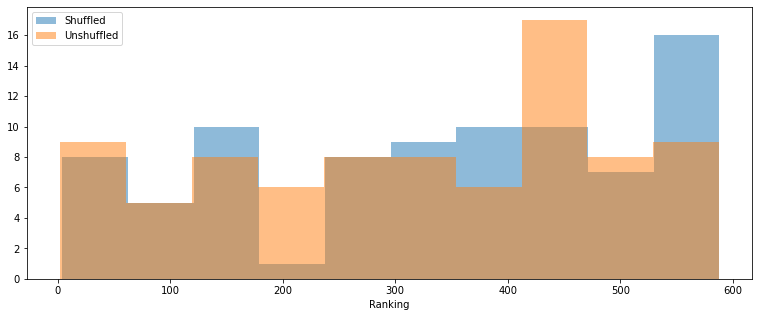

In [13]:
fig, ax = plt.subplots(figsize=(13, 5))
plt.hist(rankings_random, alpha = 0.5, label = "Shuffled")
plt.hist(rankings, alpha = 0.5, label = "Unshuffled")
plt.legend()
plt.xlabel('Ranking')
plt.show()

In [14]:
#to see which MOA combo performed the best
ranking_moa = pd.DataFrame()
for i in range(len(performance_all_combo)):
    ranking_moa = ranking_moa.append(performance_all_combo[i])
ranking_moa.sort_index()

,distance,moa
2,0.320376,cyclooxygenase inhibitor|prostanoid receptor a...
3,2.385447,NFkB pathway inhibitor|proteasome inhibitor
5,0.294806,dopamine receptor antagonist|serotonin recepto...
28,0.983759,opioid receptor agonist|opioid receptor antago...
36,0.523466,FGFR inhibitor|VEGFR inhibitor
...,...,...
563,3.189039,dehydrogenase inhibitor|inositol monophosphata...
575,3.249705,DNA alkylating agent|DNA synthesis inhibitor
578,3.291789,SRC inhibitor|tubulin polymerization inhibitor
584,3.905597,microtubule inhibitor|tubulin polymerization i...


In [15]:
print(np.mean(rankings))
print(np.mean(rankings_random))

316.95238095238096
337.2142857142857


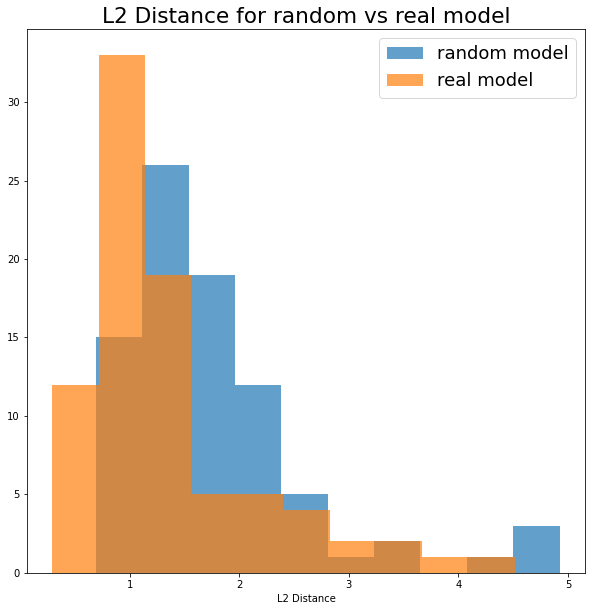

In [16]:
L2 = []
L2_random = []
for i in range(len(valid_pipes)):
    desired_moa = np.array(mean_of_moas[mean_of_moas.index == valid_pipes[i]])
    L2.append(np.linalg.norm(predictions[i][0]-desired_moa[0]))
    L2_random.append(np.linalg.norm(predictions_random[i][0]-desired_moa[0]))
    
fig, ax = plt.subplots(figsize=(10, 10))
plt.rcParams.update({'font.size': 18})
ax = plt.hist(L2_random, alpha = 0.7, label = "random model")
plt.hist(L2, alpha = 0.7, label = "real model")
plt.legend()
plt.title('L2 Distance for random vs real model')
plt.xlabel('L2 Distance')
plt.show()

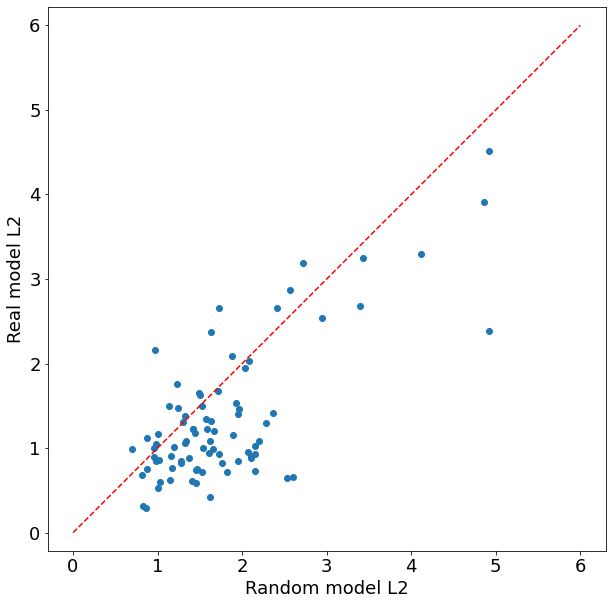

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(L2_random,L2)
plt.style.use('seaborn-whitegrid')
x = np.linspace(0, 6, 1000)
plt.plot(x,x, c = "r", linestyle = "--")
plt.xlabel('Random model L2')
plt.ylabel('Real model L2')
plt.axis('equal')
plt.show()

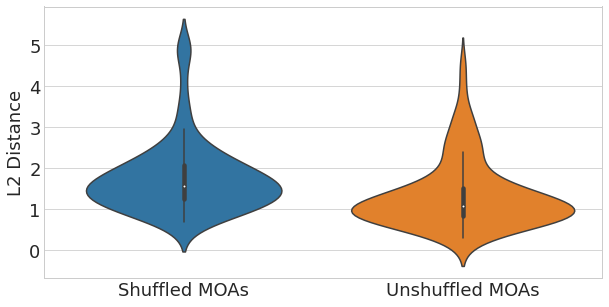

In [18]:
L2_df = pd.DataFrame()
L2_df['Shuffled MOAs'] = L2_random
L2_df['Unshuffled MOAs'] = L2
fig, ax = plt.subplots(figsize=(10, 5))
ax = seaborn.violinplot(data = L2_df)
ax.set(ylabel = "L2 Distance")
plt.show()

In [19]:
L2_df.describe()

,Shuffled MOAs,Unshuffled MOAs
count,84.000000,84.000000
mean,1.773604,1.350408
std,0.871135,0.817414
min,0.691675,0.294806
25%,1.240814,0.848405
50%,1.575906,1.083596
75%,2.069041,1.508322
max,4.923266,4.512147


In [20]:
ttest_ind(L2, L2_random)

Ttest_indResult(statistic=-3.246847572856548, pvalue=0.0014118699241241173)